In [1]:
import numpy as np
import matplotlib.pyplot as plt

lambda1 = 20
mu = 5
shift_hours = 8

np.random.seed(1)

In [2]:
def simulate_queue(s):
    inter = np.random.exponential(1/lambda1, int(lambda1*shift_hours*1.5))
    arrivals = np.cumsum(inter)
    arrivals = arrivals[arrivals < shift_hours]
    N = len(arrivals)

    services = np.random.exponential(1/mu, N)
    
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)
    dep_times = []
    
    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + services[i]
        next_free[j] = end
        dep_times.append(end)

        system_size[i] = np.sum(np.array(dep_times) > t)

    return wait_times, system_size

w1, q1 = simulate_queue(s = 1)
print(f"s=1: Average Wait = {w1.mean()*60: .1f} min, Average Queue Len {q1.mean(): .2f}")

s=1: Average Wait =  808.2 min, Average Queue Len  65.99


In [3]:
p1 = lambda1/mu
L_analytic = p1 / (1-p1)
W_analytic = L_analytic/lambda1

print("M/M/1 analytic vs simulation:")
print(f"Analytic System Size L = {L_analytic:.2f}")
print(f"Simulated Average System Size = {q1.mean():.2f}")
print(f"Analytic Time In System W = {W_analytic*60: .1f} min")
print(f"Simulated Average Wait+Service = {w1.mean()*60 + (1/mu)*60: .1f} min")

M/M/1 analytic vs simulation:
Analytic System Size L = -1.33
Simulated Average System Size = 65.99
Analytic Time In System W = -4.0 min
Simulated Average Wait+Service =  820.2 min


In [6]:
threshold = 5
results = []
for s in range(1,6):
    w,q = simulate_queue(s)
    waits_min = w*60
    p95_wait = np.percentile(waits_min, 95)
    results.append((s, waits_min.mean(), p95_wait, q.mean()))
    
import pandas as pd
df = pd.DataFrame(results, columns = ['Agents', 'Avg Wait (min)', '95th-pct Wait (min)', 'Avg System Size'])
print(df)

good = df[df['95th-pct Wait (min)'] <= threshold]
if not good.empty:
    print(f"\n-> Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
    print("\n Even 5 Agents can't meet the 5 min 95% wait target.")

   Agents  Avg Wait (min)  95th-pct Wait (min)  Avg System Size
0       1      930.399004          1618.296926        73.800000
1       2      227.080904           438.989637        37.089041
2       3      122.178682           242.771010        33.280899
3       4       20.646278            42.806675        10.708861
4       5        2.693525            19.374763         5.046980

 Even 5 Agents can't meet the 5 min 95% wait target.


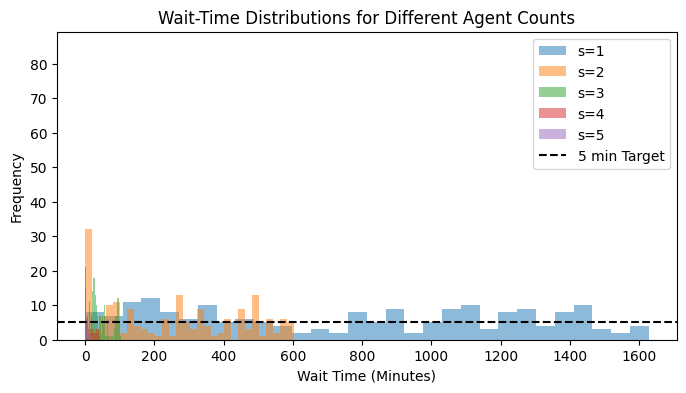

In [9]:
plt.figure(figsize=(8,4))
for s in [1,2,3,4,5]:
    w, _ = simulate_queue(s)
    plt.hist(w*60, bins = 30, alpha = 0.5, label=f's={s}')
plt.axhline(threshold, color='k', linestyle='--', label='5 min Target')
plt.xlabel('Wait Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Wait-Time Distributions for Different Agent Counts')
plt.legend()
plt.show()

In [11]:
def simulate_queue_timevarying(s):
    periods = [(0,2,30), (2,6,20), (6,8,40)]
    arrivals = []
    for start, end, lam in periods:
        duration = end - start
        inter = np.random.exponential(1/lam, int(lam*duration*1.5))
        ts = np.cumsum(inter) + start
        arrivals.extend(ts[ts < end])
    arrivals = np.array(arrivals)
    arrivals.sort()

    N = len(arrivals)
    services = np.random.exponential(1/mu, N)
    next_free = np.zeros(s)
    wait_times = np.zeros(N)

    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        next_free[j] = start + services[i]
    return wait_times

w_tv = simulate_queue_timevarying(s=3)
print(f"Time-varying ⋋, s=3 -> avg wait = {w_tv.mean()*60:.1f} min")

Time-varying ⋋, s=3 -> avg wait = 201.0 min


In [14]:
def simulate_with_abandon(s, patience=5/60):
    arrivals = np.cumsum(np.random.exponential(1/lambda1, int(lambda1*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/mu, len(arrivals))
    next_free = np.zeros(s)
    waits = []
    abandons = 0

    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait = start - t
        if wait > patience:
            abandons += 1
        else:
            waits.append(wait)
            next_free[j] = start + services[i]

    return np.array(waits), abandons/len(arrivals)

w, ab_rate = simulate_with_abandon(s=4)
print(f"Abandon Rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")

Abandon Rate (s=4): 16.96%, avg wait on served calls: 1.1 min


In [15]:
def simulate_with_breaks(s, break_start=3, break_length = 0.25):
    arrivals = np.cumsum(np.random.exponential(1/lambda1, int(lambda1*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/mu, len(arrivals))
    next_free = np.zeros(s)
    waits = []

    for i,t in enumerate(arrivals):
        avail = next_free.copy()
        if break_start < t < break_start + break_length:
            avail = np.delete(avail, 0)
        j = np.argmin(avail)
        start = max(t, avail[j])
        waits.append(start - t)
        idx = j + (1 if break_start < t < break_start + break_length else 0)
        next_free[idx] = start + services[i]
    return np.array(waits)

w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3 -> avg wait = {w_b.mean()*60:.1f} min")

With breaks, s=3 -> avg wait = 38.3 min


In [17]:
c_agent = 20
c_wait = 0.50

costs = []
for s in range(1,6):
    w, _ = simulate_with_abandon(s)
    total_wait_cost = w.sum()*60*c_wait
    staff_cost = s * c_agent * shift_hours
    costs.append((s, staff_cost + total_wait_cost))

opt = min(costs, key=lambda x:x[1])
print("Agent Count, Total Cost:")
for s,c in costs: print(f"s = {s}: ${c:,.0f}")
print(f"-> Optimal s by cost = {opt[0]}")

Agent Count, Total Cost:
s = 1: $204
s = 2: $399
s = 3: $578
s = 4: $686
s = 5: $875
-> Optimal s by cost = 1


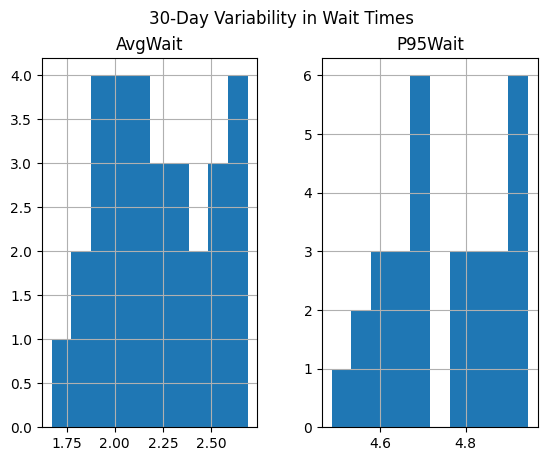

In [20]:
days = 30
daily = []
for _ in range(days):
    w, _ = simulate_with_abandon(opt[0])
    daily.append((w.mean()*60, np.percentile(w*60,95)))
df_days = pd.DataFrame(daily, columns = ['AvgWait', 'P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30-Day Variability in Wait Times')
plt.show()